In [65]:
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import anndata as ad
h5ad = sc.read_h5ad('E14-16h_a_count_normal_stereoseq.h5ad')

In [66]:
def sample_with_epidermis_frac(s, p_epi, N, random_state = None):
    """
    Sample N items from s so that fraction p_epi are 'epidermis'
    and the rest are other categories.
    """
    # 1. split the indices
    epi_idx     = s[s == 'epidermis'].index
    non_epi_idx = s[s != 'epidermis'].index

    # 2. compute how many to draw from each
    n_epi   = int(round(p_epi * N))
    n_other = N - n_epi

    # 3. sample (without replacement)
    sampled_epi   = epi_idx.to_series().sample(n=n_epi,
                                               random_state=random_state).index
    sampled_other = non_epi_idx.to_series().sample(n=n_other,
                                                   random_state=random_state).index

    # 4. pull out the sampled rows and shuffle the result
    result = s.loc[sampled_epi.union(sampled_other)]
    return result.sample(frac=1, random_state=random_state)

slide1 = h5ad[h5ad.obs.slice_ID == "E14-16h_a_S01"]
sampled = sample_with_epidermis_frac(slide1.obs.annotation, 0.8, 200)
epi_indices = sampled[sampled == 'epidermis'].index
print(slide1[epi_indices])
print(sampled.value_counts(normalize=True))

View of AnnData object with n_obs × n_vars = 160 × 13668
    obs: 'slice_ID', 'raw_x', 'raw_y', 'new_x', 'new_y', 'new_z', 'annotation'
    obsm: 'X_umap', 'spatial'
    layers: 'raw_counts'
annotation
epidermis    0.800
muscle       0.120
CNS          0.035
trachea      0.030
carcass      0.010
midgut       0.005
Name: proportion, dtype: float64


/var/folders/3n/stt0b0093kv3t84596s9fqsm0000gn/T/ipykernel_62942/2850591416.py:26: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  all_cells.obs['slice_ID'] = str(i + 1)
/var/folders/3n/stt0b0093kv3t84596s9fqsm0000gn/T/ipykernel_62942/2850591416.py:26: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  all_cells.obs['slice_ID'] = str(i + 1)
/var/folders/3n/stt0b0093kv3t84596s9fqsm0000gn/T/ipykernel_62942/2850591416.py:26: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  all_cells.obs['slice_ID'] = str(i + 1)
/var/folders/3n/stt0b0093kv3t84596s9fqsm0000gn/T/ipykernel_62942/2850591416.py:26: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  all_cells.obs['slice_ID'] = str(i + 1)
/var/folders/3n/stt0b0093kv3t84596s9fqsm0000gn/T/ipykernel_62942/2850591416.py:26: ImplicitModificat

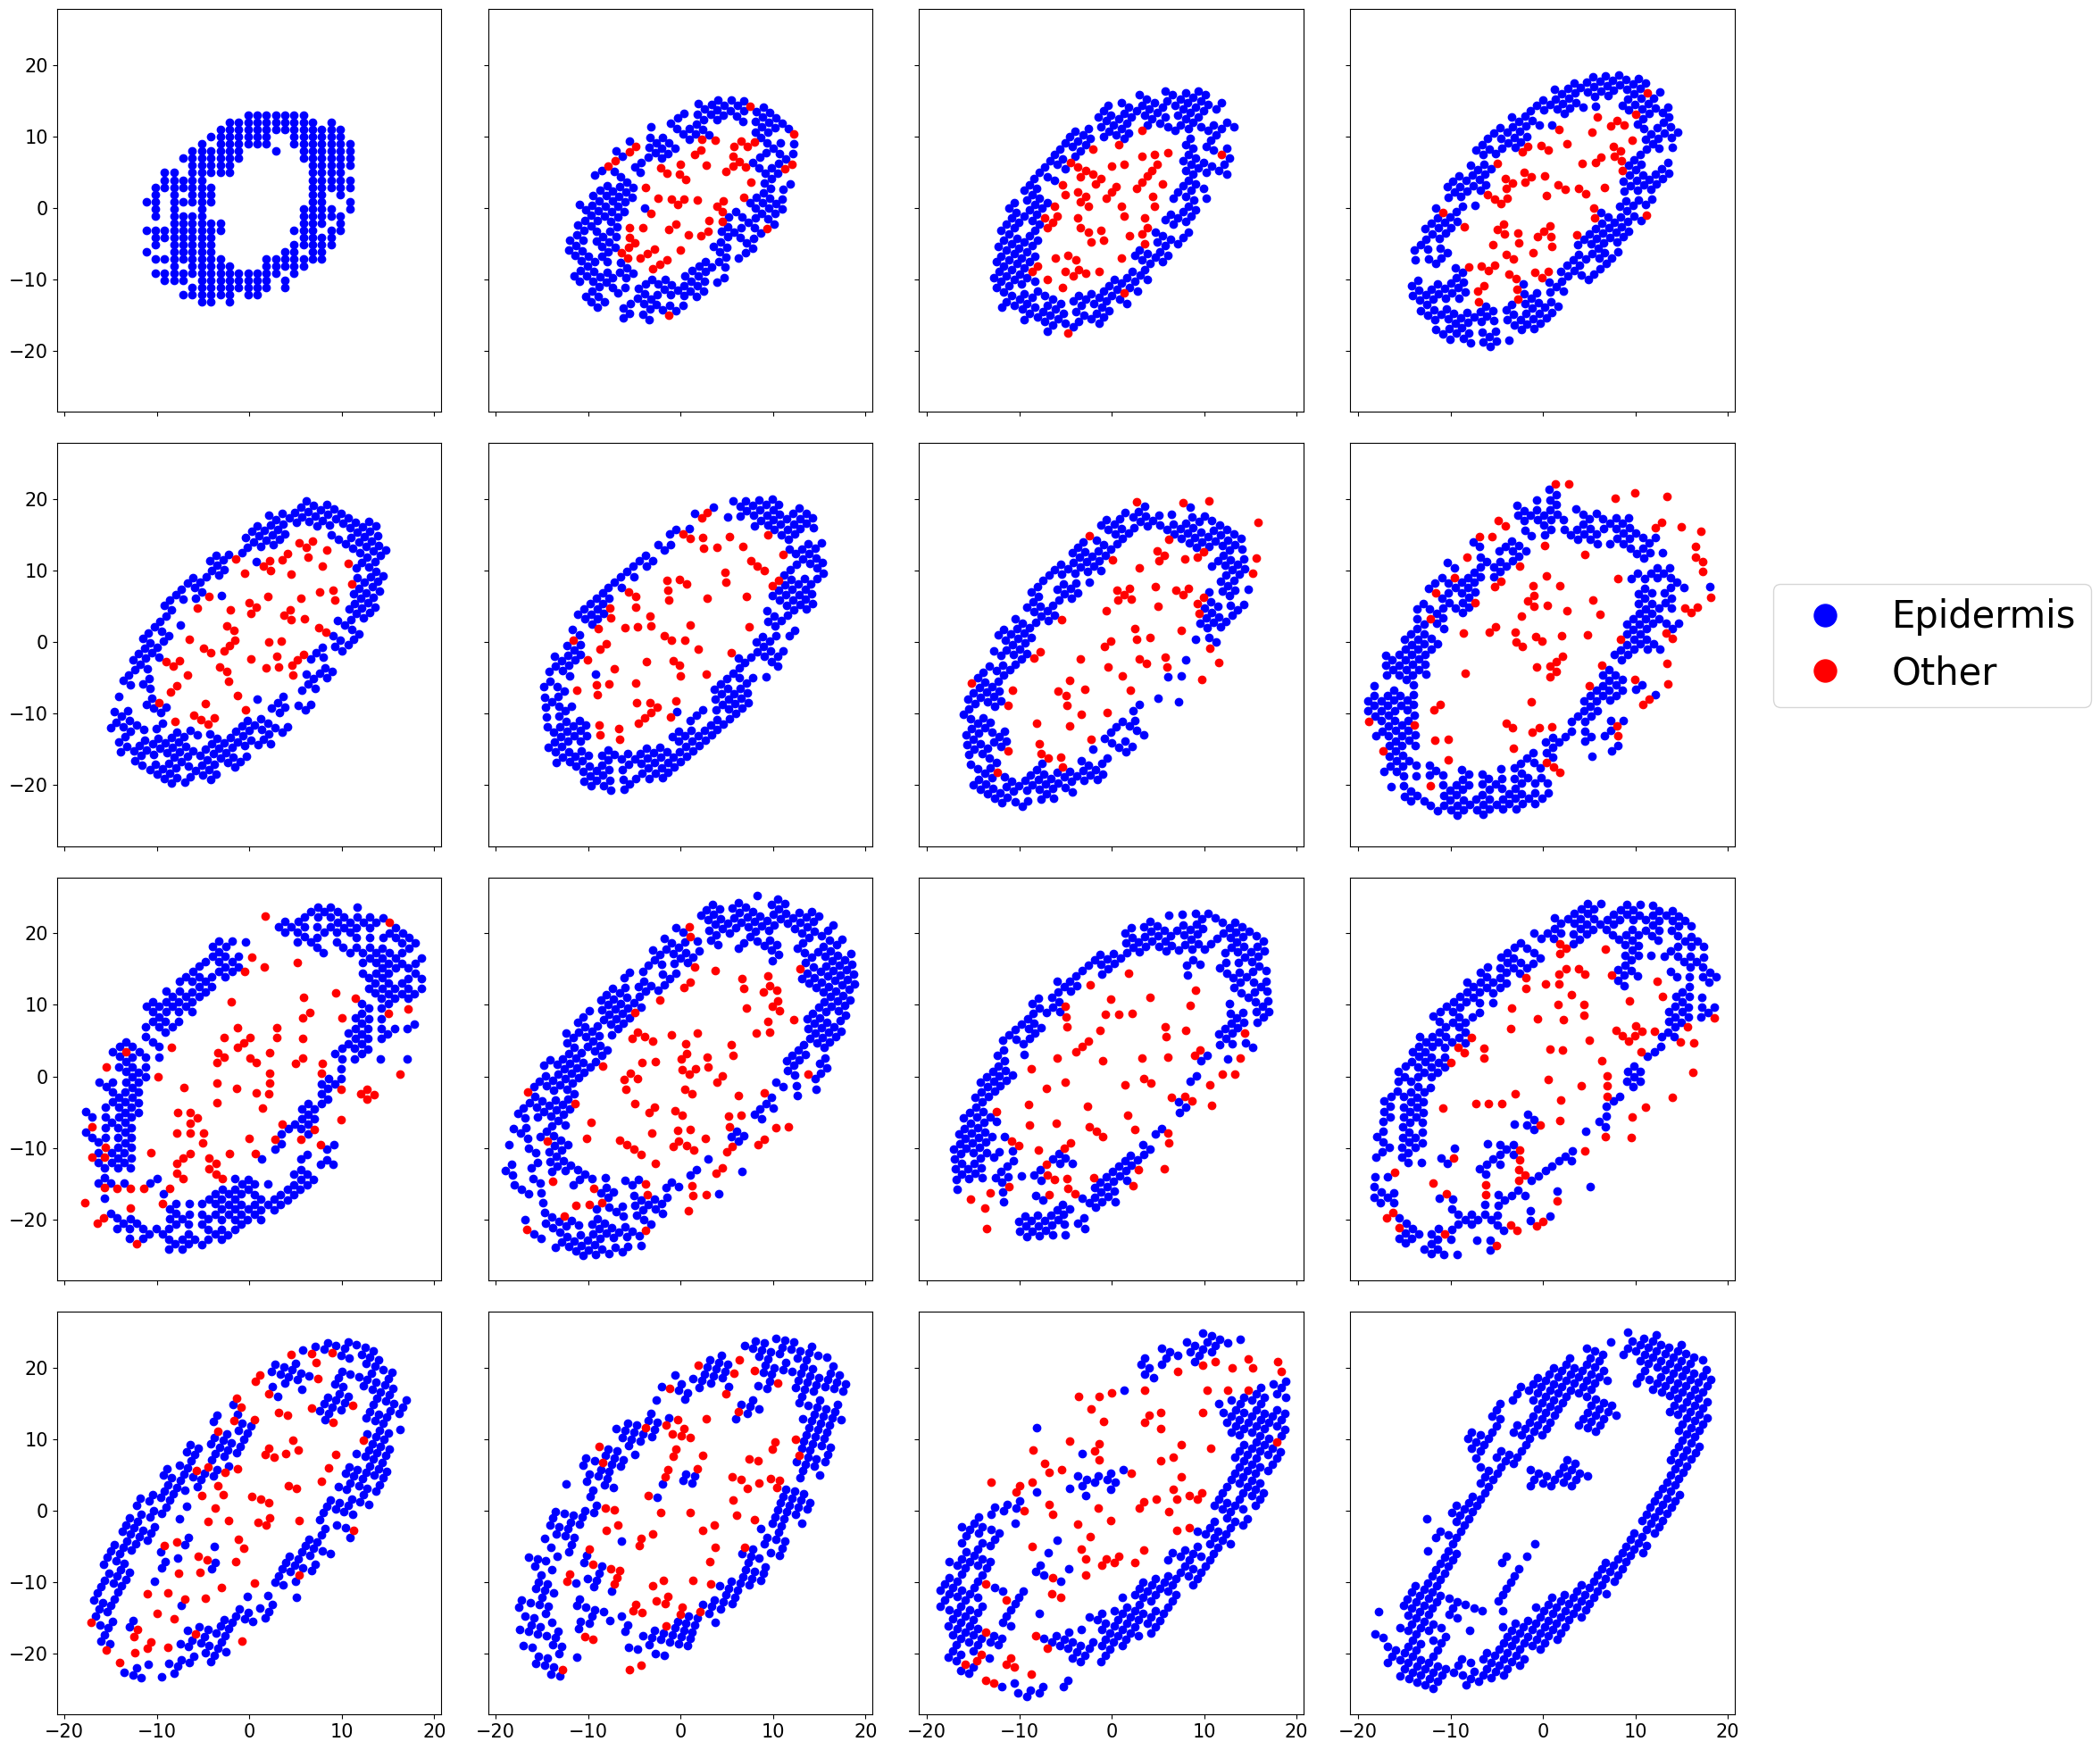

In [100]:
from matplotlib.lines import Line2D
fraction_epidermis = .8

all_slice_adata = []

fig, ax = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(20, 20))
plt.rcParams.update({'font.size': 20})
row = 0
for slide_ID in range(1, 17):
    i = slide_ID - 1
    if slide_ID < 10:
        slide_ID = "0" + str(slide_ID)
    slide = h5ad[h5ad.obs.slice_ID == f"E14-16h_a_S{slide_ID}"]

    n_epi_total = slide[slide.obs.annotation == 'epidermis'].shape[0]
    if (i == 0) | (i == 15):
        fraction_epidermis_ = 1.
    else:
        fraction_epidermis_ = fraction_epidermis
    sampled_cell_type_distribution = sample_with_epidermis_frac(slide.obs.annotation, fraction_epidermis_, n_epi_total)

    epi_cell_indices = sampled_cell_type_distribution[sampled_cell_type_distribution == 'epidermis'].index
    non_epi_cell_indices = sampled_cell_type_distribution[sampled_cell_type_distribution != 'epidermis'].index

    all_cells = slide[sampled_cell_type_distribution.index]
    all_cells.obs['slice_ID'] = str(i + 1)
    all_slice_adata.append(all_cells)

    epi_cells = slide[epi_cell_indices]
    non_epi_cells = slide[non_epi_cell_indices]

    X = epi_cells.obsm['spatial'][:, :-1]
    Y = non_epi_cells.obsm['spatial'][:, :-1]

    col = i % 4
    row = row + ((col == 0) & (i > 0))
    ax[row, col].scatter(X[:, 0], X[:, 1], c='blue', label='Epidermis')
    ax[row, col].scatter(Y[:, 0], Y[:, 1], c='red', label='Other')

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Epidermis',
                          markerfacecolor='blue', markersize=20),
                   Line2D([0], [0], marker='o', color='w', label='Other',
                          markerfacecolor='red', markersize=20)]

#
plt.tight_layout()
plt.legend(handles=legend_elements, loc=(1.1, 2.5), fontsize=30)
plt.show()

all_cells_adata = ad.concat(all_slice_adata, axis=0, merge='same')
all_cells_adata.write_h5ad(f'drosophila_p{int(100 * fraction_epidermis)}.h5ad')

In [61]:
all_cells_adata.obs.slice_ID

E14-16h_a_S01_20580x62800-0      1
E14-16h_a_S01_20880x62940-0      1
E14-16h_a_S01_20620x62900-0      1
E14-16h_a_S01_20900x63160-0      1
E14-16h_a_S01_20920x63060-0      1
                                ..
E14-16h_a_S16_61540x79320-15    16
E14-16h_a_S16_61400x79000-15    16
E14-16h_a_S16_61540x79740-15    16
E14-16h_a_S16_61400x79380-15    16
E14-16h_a_S16_61620x78820-15    16
Name: slice_ID, Length: 6279, dtype: category
Categories (16, object): ['1', '2', '3', '4', ..., '13', '14', '15', '16']